BERT for Text Classification with TensorFlow

Check if your Colab notebook is configured to use GPUs.


In [118]:
!nvidia-smi

Fri Nov 10 16:05:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   8757MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [119]:
import tensorflow as tf
print(tf.version.VERSION)

2.14.0


In [120]:
!pip install -q tensorflow

In [121]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [27]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 30.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into 

After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime)


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.14.0
Eager mode:  True
Hub version:  0.15.0
GPU is available


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("products_data.csv")
df.shape

(247, 3)

In [4]:
df.tail(20)

,product,match,url
227,Anita Espresso Power Love Seat w/ Console,1,http://www.muuduufurniture.com/products/frame-...
228,Ash Chair,1,http://www.muuduufurniture.com/products/frame-...
229,Ash Loveseat,1,http://www.muuduufurniture.com/products/frame-...
230,Ash Sofa,1,http://www.muuduufurniture.com/products/frame-...
231,Ash Sofa Set,1,http://www.muuduufurniture.com/products/frame-...
232,Asma Beige Loveseat,1,http://www.muuduufurniture.com/products/frame-...
233,Asma Beige Sofa,1,http://www.muuduufurniture.com/products/frame-...
234,Asma Beige Sofa Set,1,http://www.muuduufurniture.com/products/frame-...
235,Atlantic Chair,1,http://www.muuduufurniture.com/products/frame-...
236,Atlantic Loveseat,1,http://www.muuduufurniture.com/products/frame-...


1


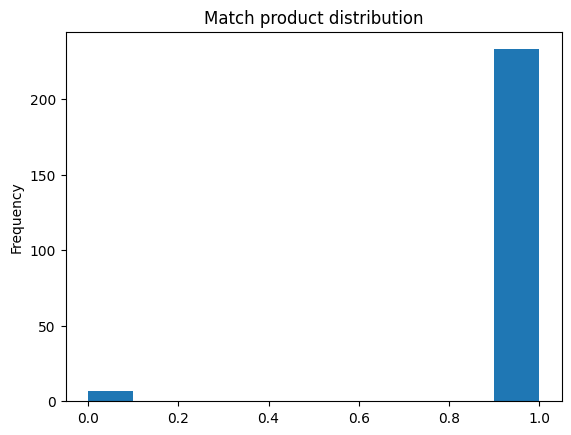

In [5]:
df['product'].replace('', np.nan, inplace=True)
df.dropna(subset=['product'], inplace=True)
df.match.plot(kind='hist', title='Match product distribution')
label = np.unique(df['match'])
print(label.sum())
#texts = df['product'].tolist()
#labels = [1 if match == "product" else 0 for match in df['match'].tolist()]

In [6]:
train_df, remaining = train_test_split(df, random_state=33, train_size=0.7, stratify=df.match.values)
valid_df, _ = train_test_split(remaining, random_state=33, train_size=0.7, stratify=remaining.match.values)
train_df.shape, valid_df.shape

((168, 3), (50, 3))

In [32]:
with tf.device('gpu'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['product'].values, train_df['match'].values))
  valid_data = train_data = tf.data.Dataset.from_tensor_slices((valid_df['product'].values, valid_df['match'].values))

  for text, label in train_data.take(1):
    print(text)
    print(label)




tf.Tensor(b'Sweden Teak Side Coffee Table 60 x 60 cm', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [33]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128  # maximum length of (token) input sequences
train_batch_size = 32


# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)



In [34]:
tokenizer.wordpiece_tokenizer.tokenize('CH24 Wishbone Chair - Beech - Soft colours')

['[UNK]', '[UNK]', '[UNK]', '-', '[UNK]', '-', '[UNK]', 'colours']

In [35]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('CH24 Wishbone Chair - Beech - Soft colours'))

[100, 100, 100, 1011, 100, 1011, 100, 8604]

Transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [36]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
   example = classifier_data_lib.InputExample(guid=None,
                                              text_a=text.numpy(),
                                              text_b=None,
                                              label=label.numpy())

   feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

   return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)





Wrap `.map` function in a `tf.py_function`

In [37]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_ids = tf.py_function(to_feature, inp=[text,label],
                                                                 Tout=[tf.int64,tf.int64,tf.int64,tf.int64])

  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_ids.set_shape([])

  x = {'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
       }

  return (x, label_ids)




Create a TensorFlow Input Pipeline with `tf.data`

In [38]:
with tf.device('cpu'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(100)
    .batch(32, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))


  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(32, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))



The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [39]:
# train data spec
train_data.element_spec


({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

In [40]:
# valid data spec
valid_data.element_spec


({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

Add a Classification Head to the BERT Layer

In [41]:
from os import name
from tensorflow.python.ops.gen_math_ops import segment_max
from tensorflow.python.util.nest_util import sequence_like
# Building the model
def create_model():
  input_word_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name='input_word_ids')
  input_mask=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name='input_mask')
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name='input_type_ids')
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)

  model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
      },
      outputs=output)

  return model



Fine-Tune BERT for Text Classification

In [42]:
model = create_model()
model.compile(tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

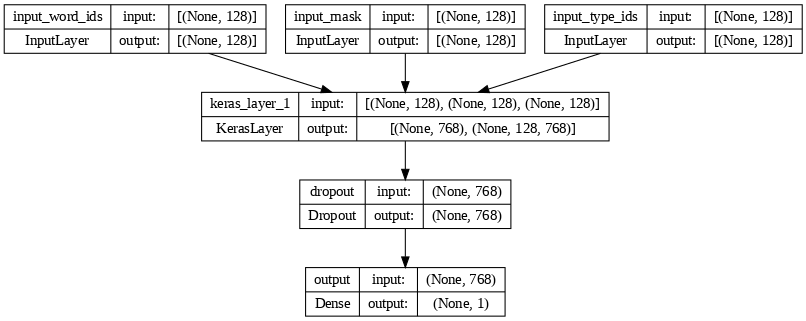

In [55]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [43]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)


Epoch 1/4
1/1 [==============================] - 49s 49s/step - loss: 0.4905 - binary_accuracy: 0.8125 - val_loss: 0.2485 - val_binary_accuracy: 1.0000
Epoch 2/4
1/1 [==============================] - 1s 1s/step - loss: 0.3293 - binary_accuracy: 0.9375 - val_loss: 0.1568 - val_binary_accuracy: 1.0000
Epoch 3/4
1/1 [==============================] - 1s 1s/step - loss: 0.3098 - binary_accuracy: 0.9062 - val_loss: 0.1056 - val_binary_accuracy: 1.0000
Epoch 4/4
1/1 [==============================] - 1s 1s/step - loss: 0.1296 - binary_accuracy: 1.0000 - val_loss: 0.0693 - val_binary_accuracy: 1.0000


Evaluate Model

In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

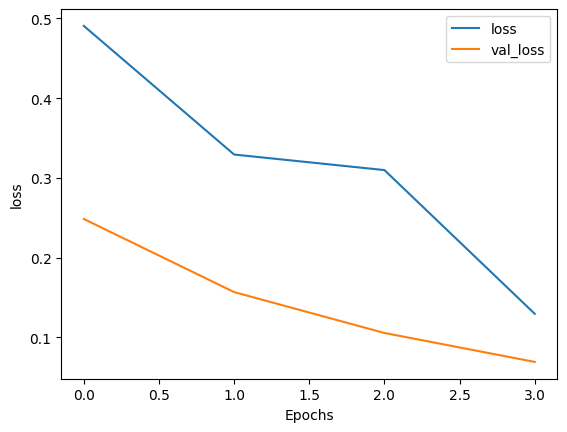

In [46]:
plot_graphs(history, 'loss')

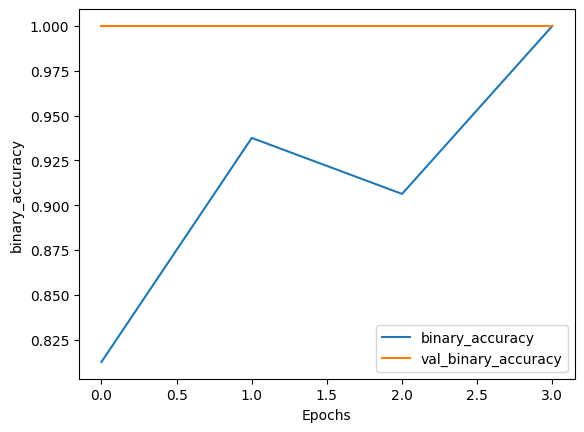

In [47]:
plot_graphs(history, 'binary_accuracy')

In [48]:
sample_example =['Beadlight Cirrus LED Reading Light', 'CH24 Wishbone Chair - Beech - Soft colours']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(2))
preds = model.predict(test_data)
treshold = 1
['match' if preds.any() >= treshold else 'not match' for pred in preds]

1/1 [==============================] - 1s 569ms/step


['match', 'match']